# Factor Analysis

## 导入数据

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('data/2023 QS World University Rankings.csv')

first_two_columns = data.iloc[:240,:2]
other_we_want = data.iloc[:240,4:15:2]
last_column = data.iloc[:240,-1]
data_used = pd.concat([last_column, first_two_columns,other_we_want],axis=1)

data_used.head()

,score scaled,Rank,institution,ar score,er score,fsr score,cpf score,ifr score,isr score
0,100,1,Massachusetts Institute of Technology (MIT),100.0,100.0,100.0,100.0,100.0,90.0
1,98.8,2,University of Cambridge,100.0,100.0,100.0,92.3,100.0,96.3
2,98.5,3,Stanford University,100.0,100.0,100.0,99.9,99.8,60.3
3,98.4,4,University of Oxford,100.0,100.0,100.0,90.0,98.8,98.4
4,97.6,5,Harvard University,100.0,100.0,99.4,100.0,76.9,66.9


## 数据预处理

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
standardized = StandardScaler().fit_transform(data_used.iloc[:,3:])

standardized_df = pd.DataFrame(standardized,columns=data_used.columns[3:])
standardized_df.head()
# indices = np.where(data_used.isnull())
# # 输出缺失值的坐标
# for row, col in zip(indices[0], indices[1]):
#     print(f"缺失值的坐标：行 {row}，列 {col}")

,ar score,er score,fsr score,cpf score,ifr score,isr score
0,1.590269,1.477666,1.447563,1.415771,1.065306,1.083970
1,1.590269,1.477666,1.447563,1.138985,1.065306,1.277161
2,1.590269,1.477666,1.447563,1.412176,1.059243,0.173208
3,1.590269,1.477666,1.447563,1.056309,1.028931,1.341559
4,1.590269,1.477666,1.428576,1.415771,0.365096,0.375600


## 检验数据
bartlett检验，因为小于0.05，所以说明变量之间存在相关性，所以适合做因子分析

In [4]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(standardized_df)
chi_square_value, p_value

(374.89713014177653, 1.2851838434169066e-70)

In [5]:
#KMO检验
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(standardized_df)
kmo_model

0.5296452879715545

In [6]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(4, method = "principal", rotation="varimax")

fa.fit(standardized_df)

# 得到original eigenvalues和common factor eigenvalues
ev,v=fa.get_eigenvalues()
ev,v

(array([1.93347604, 1.74562516, 0.99457125, 0.75606888, 0.31236672,
        0.25789196]),
 array([1.81660512, 1.62400965, 0.9689425 , 0.72626654, 0.17419752,
        0.11971999]))

## 选择合适的因子个数

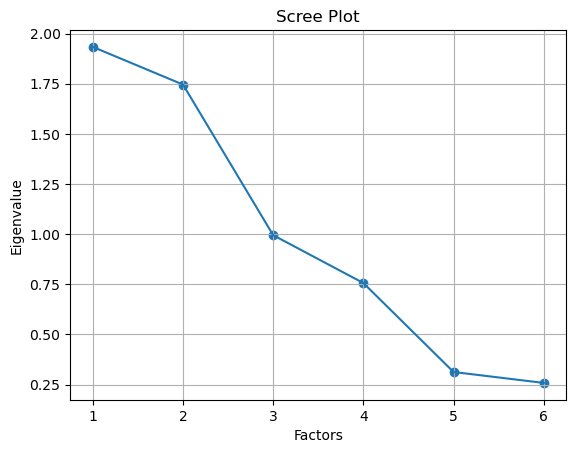

In [7]:
import matplotlib.pyplot as plt
# 同样的数据绘制散点图和折线图
plt.scatter(range(1, standardized_df.shape[1] + 1), ev)
plt.plot(range(1, standardized_df.shape[1] + 1), ev)
 
# 显示图的标题和xy轴的名字

plt.title("Scree Plot")  
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
 
plt.grid()  # 显示网格
plt.show()  # 显示图形

## 实验结果

### 载荷矩阵

In [8]:
fa.loadings_

array([[-0.02092651,  0.90998171,  0.07087065,  0.12672711],
       [ 0.05932603,  0.92250019,  0.0623015 , -0.07100248],
       [ 0.00178266,  0.09941939,  0.99327555, -0.0582102 ],
       [ 0.19017568,  0.04654115, -0.06109442,  0.97305026],
       [ 0.89346106, -0.13401802, -0.02635109,  0.19686469],
       [ 0.91582137,  0.17221854,  0.02646946,  0.05629123]])

### communalities - 所有因子对$x_i$的影响

In [9]:
fa.get_communalities()

array([0.84958703, 0.86344902, 0.99987215, 0.9888922 , 0.85568358,
       0.87225734])

### factor_variance - 一个因子解释的方差百分比

In [10]:
fa.get_factor_variance()

(array([1.67712891, 1.73874366, 1.00062799, 1.01324075]),
 array([0.27952149, 0.28979061, 0.16677133, 0.16887346]),
 array([0.27952149, 0.5693121 , 0.73608343, 0.90495689]))

### 可视化结果

Text(120.72222222222221, 0.5, 'Sepal Width')

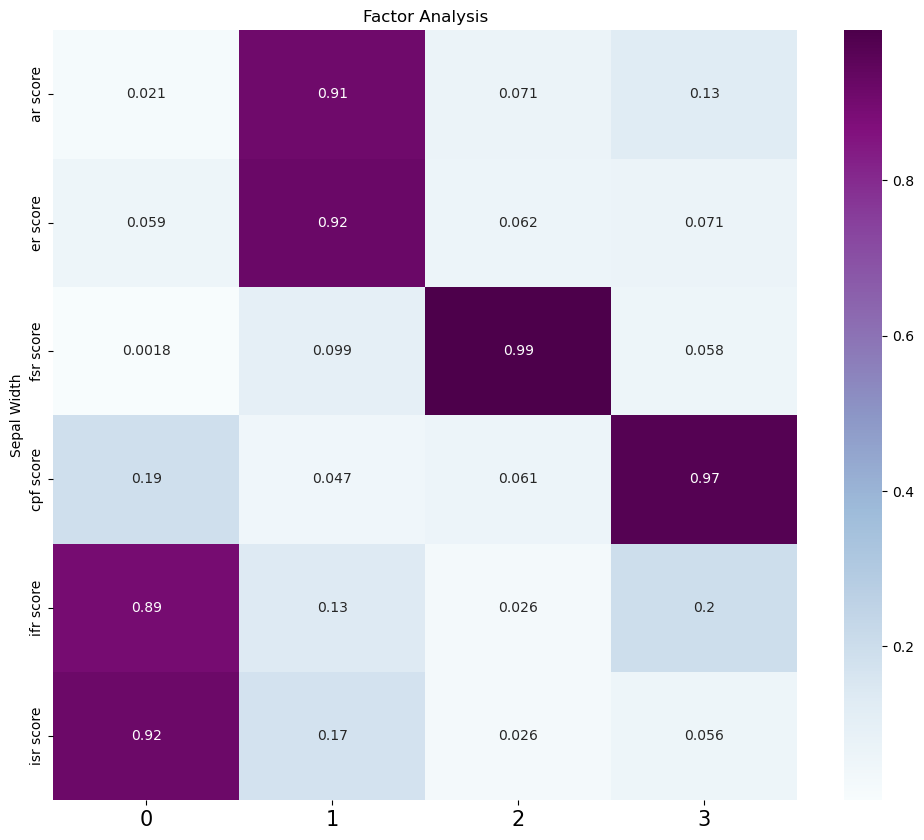

In [11]:
import seaborn as sns
df_cm = pd.DataFrame(np.abs(fa.loadings_),index=standardized_df.columns)

fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(df_cm,annot=True,cmap='BuPu',ax=ax)
# 设置y轴字体的大小
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("Sepal Width")

### 得分

In [12]:
## 输出因子的weight
factor_weight = np.sum(np.square(fa.loadings_), axis=0)/np.sum(np.sum(np.square(fa.loadings_), axis=0))
factor_weight

array([0.30887823, 0.32022587, 0.18428649, 0.1866094 ])

In [13]:
scores = fa.transform(standardized_df)@factor_weight
scores[:5]

array([1.27200512, 1.26196396, 1.11532535, 1.25532307, 1.05584366])

### 排名

In [14]:

score_df = pd.DataFrame(scores,columns=["New Scores"])
max = score_df.max()
min = score_df.min()

score_df = ((score_df - min) / (max - min) * 100).round(1)

offset = (-min/(max-min)*100).round(1)
print(offset)
score_df['New Rank'] = score_df['New Scores'].rank(ascending=False).astype(int)

scored_data = pd.concat([data_used.iloc[:,2], data_used.iloc[:,:2], score_df], axis = 1)

scored_data = scored_data.rename(columns={'Rank':'Original Rank'})
scored_data

New Scores    41.8
dtype: float64


,institution,score scaled,Original Rank,New Scores,New Rank
0,Massachusetts Institute of Technology (MIT),100,1,100.0,1
1,University of Cambridge,98.8,2,99.5,2
2,Stanford University,98.5,3,92.8,7
3,University of Oxford,98.4,4,99.2,3
4,Harvard University,97.6,5,90.1,9
...,...,...,...,...,...
235,"University of California, Irvine",39.5,236,19.7,193
236,King Saud University,39.4,237,14.9,208
237,University of Cape Town,39.4,238,14.3,212
238,University of Ottawa,39.4,239,27.2,166


In [15]:
# 输出排名相差大于5的
print(np.where(abs(scored_data["Original Rank"] - scored_data["New Rank"]) > 5)[0])

stable_index = np.where(abs(scored_data["Original Rank"] - scored_data["New Rank"]) <= 2)
print(scored_data['institution'].iloc[stable_index])

[ 11  13  16  19  22  23  24  25  26  27  28  30  31  32  33  34  35  36
  39  40  41  42  43  44  45  47  48  49  50  52  53  54  55  56  58  59
  60  61  63  64  65  67  68  69  70  71  72  73  75  76  77  78  79  80
  81  82  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 102 103 104 105 106 108 109 110 111 112 113 114 117 119 120 121 122
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 189 190 191 192 193 194 195 196 197
 200 201 202 203 204 205 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 223 224 225 228 229 231 232 233 234 235 236 237 238 239]
0           Massachusetts Institute of Technology (MIT) 
1                                University of Cambridge
3                                   University of Oxford
5           California Instit

## K-means聚类

### 这一步是为了得到因子分析的因子每一项的分数，也就是一个240*4的矩阵

In [16]:
factor_score = fa.transform(standardized_df)

max = factor_score.max(axis=0)
min = factor_score.min(axis=0)

factor_score = ((factor_score - min) / (max - min) * 100).round(1)

offset = (-min/(max-min)*100).round(1)
print(offset)

factor_score_df = pd.DataFrame(factor_score,columns=["International Diversity","Overall Reputation","L/T Environment","Overall Research Level"])
# factor_score_df.iloc[232,:]
# # np.where(factor_score_df["International Diversity"] == 100)[0]
# data["institution"][232]
print(factor_score_df.shape)
factor_score_df.head()

[56.9 59.  49.3 52.8]
(240, 4)


,International Diversity,Overall Reputation,L/T Environment,Overall Research Level
0,84.5,95.0,90.6,83.7
1,88.8,95.5,90.1,76.2
2,69.2,93.3,90.9,87.7
3,89.6,95.8,89.9,73.9
4,61.9,95.4,90.3,87.1


### 1 原始数据进行K-means聚类

### 1.1 确定K

c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


916872.7516104347


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


743976.2113101853


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


649183.9586386555


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


569140.7709306198


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


529962.3990870957


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


484186.7591360529


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


447595.21180207166


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


411927.5367972887


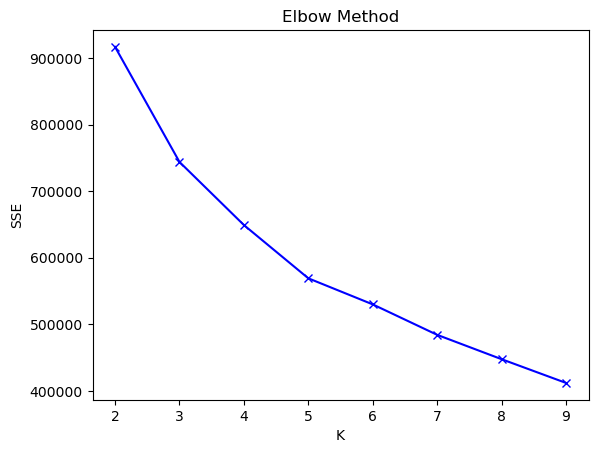

In [17]:
# K-means to cluster the universities and calculate the average score of each cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
original_data = data_used.iloc[:,2:]
k_values = range(2, 10)
sse = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(original_data.iloc[:,1:])
    print(kmeans.inertia_)

    # 计算误差平方和
    sse.append(kmeans.inertia_)
    
    # 计算轮廓系数
    labels = kmeans.labels_
    score = silhouette_score(original_data.iloc[:,1:], labels)
    silhouette_scores.append(score)
# 绘制K值和误差平方和的关系图
plt.plot(k_values, sse, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

### 1.2 聚类结果

In [18]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(original_data.iloc[:,1:])

c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [19]:
labeled_original_data = pd.concat([original_data.iloc[:,0],data["location"] ,pd.DataFrame(kmeans.labels_, columns=["Labels"]), factor_score_df], axis=1)

labeled_original_data.head()

,institution,location,Labels,International Diversity,Overall Reputation,L/T Environment,Overall Research Level
0,Massachusetts Institute of Technology (MIT),United States,0.0,84.5,95.0,90.6,83.7
1,University of Cambridge,United Kingdom,0.0,88.8,95.5,90.1,76.2
2,Stanford University,United States,0.0,69.2,93.3,90.9,87.7
3,University of Oxford,United Kingdom,0.0,89.6,95.8,89.9,73.9
4,Harvard University,United States,0.0,61.9,95.4,90.3,87.1


In [20]:
labeled = labeled_original_data.groupby("Labels")
group1 = labeled.get_group(0)
group2 = labeled.get_group(1)
group3 = labeled.get_group(2)
group4 = labeled.get_group(3)
group5 = labeled.get_group(4)

print(group1.head())

                                    institution        location  Labels  \
0  Massachusetts Institute of Technology (MIT)    United States     0.0   
1                       University of Cambridge  United Kingdom     0.0   
2                           Stanford University   United States     0.0   
3                          University of Oxford  United Kingdom     0.0   
4                            Harvard University   United States     0.0   

   International Diversity  Overall Reputation  L/T Environment  \
0                     84.5                95.0             90.6   
1                     88.8                95.5             90.1   
2                     69.2                93.3             90.9   
3                     89.6                95.8             89.9   
4                     61.9                95.4             90.3   

   Overall Research Level  
0                    83.7  
1                    76.2  
2                    87.7  
3                    73.9  
4     

### 1.3 分类结果检查地域

In [21]:
def print_state(df, column, i):
    value_counts = df[column].value_counts()
    print(f"Group{i}")
    print(value_counts)
    print()

In [22]:
print_state(group1, "location", 1)
print_state(group2, "location", 2)
print_state(group3, "location", 3)
print_state(group4, "location", 4)
print_state(group5, "location", 5)

Group1
United States       15
United Kingdom      11
Australia            6
China (Mainland)     3
Hong Kong SAR        3
Canada               3
Switzerland          2
Singapore            2
France               2
Germany              1
Netherlands          1
Name: location, dtype: int64

Group2
United States           7
Germany                 5
Norway                  2
Saudi Arabia            2
Canada                  2
France                  2
China (Mainland)        2
Denmark                 2
South Korea             2
Finland                 1
Switzerland             1
Netherlands             1
Belgium                 1
United Arab Emirates    1
Sweden                  1
Israel                  1
Russia                  1
Name: location, dtype: int64

Group3
United States       16
China (Mainland)     5
Germany              4
Netherlands          3
Italy                3
India                3
Spain                3
Brazil               2
South Korea          1
France           

### 1.4 分类结果指标可视化 - 六芒星

In [23]:
import plotly.graph_objects as go

categories = ['Academic Reputation', 'Employer Reputation', 'Faculty Student Ratio', 'Citations per faculty',
                'International Faculty Ratio', 'International Student Ratio']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=kmeans.cluster_centers_[0],
    theta=categories,
    fill='toself',
    name='Group 1'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans.cluster_centers_[1],
    theta=categories,
    fill='toself',
    name='Group 2'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans.cluster_centers_[2],
    theta=categories,
    fill='toself',
    name='Group 3'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans.cluster_centers_[3],
    theta=categories,
    fill='toself',
    name='Group 4'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans.cluster_centers_[4],
    theta=categories,
    fill='toself',
    name='Group 5'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True
        )),
    title=go.layout.Title(text=f"Radar Plot for Original Variables Cluster", x=0.5),
    showlegend=True
)

fig.show()


### 1.5 分类结果在因子分析后的各项指标 以及可视化

In [24]:
import plotly.graph_objects as go

categories = factor_score_df.columns

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=group1.iloc[:,-4:].mean(axis=0),
    theta=categories,
    fill='toself',
    name='Group 1'
))

fig.add_trace(go.Scatterpolar(
    r=group2.iloc[:,-4:].mean(axis=0),
    theta=categories,
    fill='toself',
    name='Group 2'
))

fig.add_trace(go.Scatterpolar(
    r=group3.iloc[:,-4:].mean(axis=0),
    theta=categories,
    fill='toself',
    name='Group 3'
))

fig.add_trace(go.Scatterpolar(
    r=group4.iloc[:,-4:].mean(axis=0),
    theta=categories,
    fill='toself',
    name='Group 4'
))

fig.add_trace(go.Scatterpolar(
    r=group5.iloc[:,-4:].mean(axis=0),
    theta=categories,
    fill='toself',
    name='Group 5'
))
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True
        )),
    title=go.layout.Title(text=f"Factor Radar Plot for Original Variables Cluster", x=0.5),
    showlegend=True
)

fig.show()

### 2 因子分析之后的数据进行聚类

### 2.1 用因子值 乘以 得分进行聚类 - `注意：`聚类不能放缩，会导致结果不一样

In [25]:
weighted_factor = fa.transform(standardized_df) #* factor_weight
weighted_factor_df = pd.DataFrame(weighted_factor,columns=["International Diversity","Overall Reputation","L/T Environment","Overall Research Level"])
print(weighted_factor_df.shape)
weighted_factor_df.head()

(240, 4)


,International Diversity,Overall Reputation,L/T Environment,Overall Research Level
0,0.971664,1.482326,1.379241,1.302317
1,1.121766,1.502647,1.360622,0.983572
2,0.434145,1.410052,1.387437,1.468341
3,1.150835,1.512964,1.355047,0.887672
4,0.176792,1.498493,1.367372,1.443616


c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory le

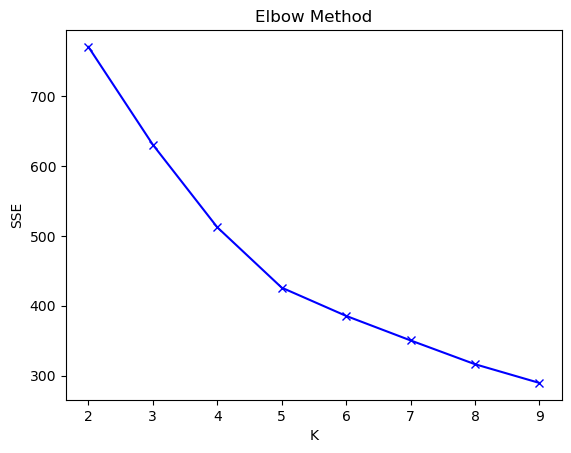

In [26]:
from sklearn.cluster import KMeans
original_data = data_used.iloc[:,2:]
k_values = range(2, 10)
sse = []
silhouette_scores = []
for k in k_values:
    kmeans_factor = KMeans(n_clusters=k, random_state=0, n_init=10).fit(weighted_factor_df)
    # print(kmeans.inertia_)

    # 计算误差平方和
    sse.append(kmeans_factor.inertia_)
    
    # 计算轮廓系数
    labels = kmeans_factor.labels_
    score = silhouette_score(weighted_factor_df, labels)
    silhouette_scores.append(score)
# 绘制K值和误差平方和的关系图
plt.plot(k_values, sse, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

### 2.2 聚类结果

In [27]:
kmeans_factor = KMeans(n_clusters=5, random_state=0, n_init=10).fit(weighted_factor_df) 

c:\Users\SouthCat\anaconda3\envs\cs324\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [28]:
labeled_factor_data = pd.concat([original_data.iloc[:,0],data["location"] ,pd.DataFrame(kmeans_factor.labels_, columns=["Labels"]), factor_score_df], axis=1)

labeled_factor_data.head()

,institution,location,Labels,International Diversity,Overall Reputation,L/T Environment,Overall Research Level
0,Massachusetts Institute of Technology (MIT),United States,2.0,84.5,95.0,90.6,83.7
1,University of Cambridge,United Kingdom,2.0,88.8,95.5,90.1,76.2
2,Stanford University,United States,2.0,69.2,93.3,90.9,87.7
3,University of Oxford,United Kingdom,2.0,89.6,95.8,89.9,73.9
4,Harvard University,United States,2.0,61.9,95.4,90.3,87.1


In [29]:
factor_labeled = labeled_factor_data.groupby("Labels")
factor_group1 = factor_labeled.get_group(0)
factor_group2 = factor_labeled.get_group(1)
factor_group3 = factor_labeled.get_group(2)
factor_group4 = factor_labeled.get_group(3)
factor_group5 = factor_labeled.get_group(4)

print(group1.head())

                                    institution        location  Labels  \
0  Massachusetts Institute of Technology (MIT)    United States     0.0   
1                       University of Cambridge  United Kingdom     0.0   
2                           Stanford University   United States     0.0   
3                          University of Oxford  United Kingdom     0.0   
4                            Harvard University   United States     0.0   

   International Diversity  Overall Reputation  L/T Environment  \
0                     84.5                95.0             90.6   
1                     88.8                95.5             90.1   
2                     69.2                93.3             90.9   
3                     89.6                95.8             89.9   
4                     61.9                95.4             90.3   

   Overall Research Level  
0                    83.7  
1                    76.2  
2                    87.7  
3                    73.9  
4     

### 2.2 分类结果检查地域

In [30]:
print_state(factor_group1, "location", 1)
print_state(factor_group2, "location", 2)
print_state(factor_group3, "location", 3)
print_state(factor_group4, "location", 4)
print_state(factor_group5, "location", 5)

Group1
United States       14
Germany              4
Italy                3
Spain                3
Taiwan               2
Brazil               2
China (Mainland)     2
India                2
France               1
Japan                1
Belgium              1
Netherlands          1
Denmark              1
Chile                1
South Africa         1
Name: location, dtype: int64

Group2
United Kingdom    23
Australia         12
Netherlands        7
Sweden             6
Canada             4
United States      3
New Zealand        2
Ireland            2
Switzerland        2
Germany            2
Austria            2
Belgium            2
Hong Kong SAR      1
Saudi Arabia       1
Qatar              1
Name: location, dtype: int64

Group3
United States       16
United Kingdom       7
China (Mainland)     5
Hong Kong SAR        3
Japan                3
Canada               3
Switzerland          2
Singapore            2
France               2
South Korea          2
Australia            2
Name: 

### 2.3 分类结果指标可视化 - 六芒星

In [31]:
import plotly.graph_objects as go

categories = ['International Diversity', 'Overall Reputation', 'L/T Environment', 'Overall Research Level']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=kmeans_factor.cluster_centers_[0],
    theta=categories,
    fill='toself',
    name='Group 1'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans_factor.cluster_centers_[1],
    theta=categories,
    fill='toself',
    name='Group 2'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans_factor.cluster_centers_[2],
    theta=categories,
    fill='toself',
    name='Group 3'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans_factor.cluster_centers_[3],
    theta=categories,
    fill='toself',
    name='Group 4'
))

fig.add_trace(go.Scatterpolar(
    r=kmeans_factor.cluster_centers_[4],
    theta=categories,
    fill='toself',
    name='Group 5'
))
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True
        )),
    title=go.layout.Title(text=f"Radar Plot for Factor Cluster", x=0.5),
    showlegend=True
)

fig.show()


In [32]:
factor_group3

,institution,location,Labels,International Diversity,Overall Reputation,L/T Environment,Overall Research Level
0,Massachusetts Institute of Technology (MIT),United States,2.0,84.5,95.0,90.6,83.7
1,University of Cambridge,United Kingdom,2.0,88.8,95.5,90.1,76.2
2,Stanford University,United States,2.0,69.2,93.3,90.9,87.7
3,University of Oxford,United Kingdom,2.0,89.6,95.8,89.9,73.9
4,Harvard University,United States,2.0,61.9,95.4,90.3,87.1
5,California Institute of Technology (Caltech),United States,2.0,81.7,86.9,91.9,85.5
6,Imperial College London,United Kingdom,2.0,91.6,94.8,89.3,70.4
7,UCL,United Kingdom,2.0,92.4,95.2,86.9,62.3
8,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,2.0,88.7,92.2,66.4,81.5
9,University of Chicago,United States,2.0,70.3,92.1,83.7,74.8
